# Lecture 8 — Machine Learning II, Regression: Gaussian Processes

#### *"The actual science of logic is conversant at present only with things either certain, impossible, or entirely doubtful, none of which (fortunately) we have to reason on. Therefore the true logic for this world is the calculus of Probabilities, which takes account of the magnitude of the probability which is, or ought to be, in a reasonable man’s mind."* (James Clerk Maxwell)


**Learning Outcomes**

- Understand Gaussian Processes (GPs) as *nonparametric*, flexible regression models.
- Define a GP regression model mathematically (prior, kernel/covariance, posterior).
- Recognize common terminology (kernel, length scale, signal variance, noise, marginal likelihood).
- Implement GP regression using `scikit-learn`.

## Motivation and History
In chemical engineering we often face nonlinear models (reaction kinetics, transport, thermodynamics).
Linear models may be too restrictive. Neural networks give flexible *parametric* function fits; **Gaussian Processes** take a different route:
they put a **distribution over functions** and deliver **predictions with uncertainty**.

- **Parametric** view (e.g., NN): choose a finite set of parameters $\theta$, then fit $f(x;\theta)$.
- **Nonparametric** view (GP): specify a prior over functions $f\sim\mathcal{GP}(m,k)$; conditioning on data yields a posterior over functions.

We will use the **distribution of functions** (and numbers) analogy to explain GPs: instead of committing to one curve, we reason over many plausible curves consistent with observed data.

Let's take a look at the slide deck I will show in class for a better explanation of how GPs work.

## Mathematical Formulation

A **Gaussian Process (GP)** says:  
- Any collection of function values is jointly Gaussian (normal).  
- To define it, we only need:  
  - a **mean function** $m(x)$ (the average shape),  
  - a **kernel** $k(x, x’)$ (how similar two points are).  

We write this as:

$$ f(x) \sim GP\big(m(x), k(x,x’)\big). $$



### Predictions with data

Suppose we have training data $(x_i, y_i)$ with some Gaussian noise. Then, for a new point $x_*$:

- The **predicted mean** (best guess) is:

$$ m(x_*) \;=\; k_* \,(K + \sigma_n^2 I)^{-1} \, y, $$

- The **predicted variance** (uncertainty) is:

$$ v(x_*) \;=\; k(x_*,x_*) \;-\; k_* \,(K + \sigma_n^2 I)^{-1} k_*^\top. $$



Where:

- $K$: the “similarity matrix” between all training points.  
- $k_*$: the similarity between the new point $x_*$ and each training point.  
- $\sigma_n^2$: the noise level (how noisy the data is).  
- $m(x_*)$: our best estimate at $x_*$.  
- $v(x_*)$: our uncertainty at $x_*$.  



**Intuition:** The GP **looks at how similar** the new point is to the training data.  
The prediction is a **weighted average** of known outputs, and the uncertainty grows when we’re far from data.

Let's take a moment to take a look at this cool website.

- [A visual Exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/)

### Kernels [(covariance functions)](https://www.cs.toronto.edu/~duvenaud/cookbook/)
- **RBF/Gaussian**: $k_{\text{RBF}}(x,x') = \sigma_f^2 \exp\!\big(-\tfrac{1}{2}\|x-x'\|^2/\ell^2\big)$
- **Matérn** (e.g., $\nu = 3/2$ or $5/2$): roughness controlled by $\nu$
- **Periodic**: encodes periodic behavior
- Plus composition: sums/products to encode additive or multiplicative structure

**Hyperparameters**: length scale $\ell$, signal variance $\sigma_f^2$, noise variance $\sigma_n^2$. These play a role analogous to NN architecture/regularization choices.

### Training = Hyperparameter optimization (marginal likelihood)
Like Lecture 7 framed NN training as an optimization, in GPs we typically choose kernel hyperparameters $\theta$ by **maximizing the log marginal likelihood**:

$$\log p(\mathbf{y}\,|\,X,\theta) = -\tfrac{1}{2}\mathbf{y}^\top(K_\theta+\sigma_n^2 I)^{-1}\mathbf{y}
 - \tfrac{1}{2}\log\det(K_\theta+\sigma_n^2 I) - \tfrac{N}{2}\log 2\pi.$$

This automatically balances data fit and model complexity through the log-determinant term.

## An example

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("logzsv.csv", index_col=0)
df

,conc,zsv,log-conc,log-zsv
ExptNo.,,,,
1,1.80,1.343571,0.587787,0.295331
2,7.50,470.248800,2.014903,6.153262
3,31.60,4.892228,3.453157,1.587648
4,133.40,9.687286,4.893352,2.270814
5,562.30,1.586862,6.332036,0.461759
6,3.16,1.385140,1.150572,0.325801
7,5.21,4.537974,1.650580,1.512481
8,11.02,57.865808,2.399712,4.058127
9,18.17,8.042775,2.899772,2.084774


Text(0, 0.5, 'y')

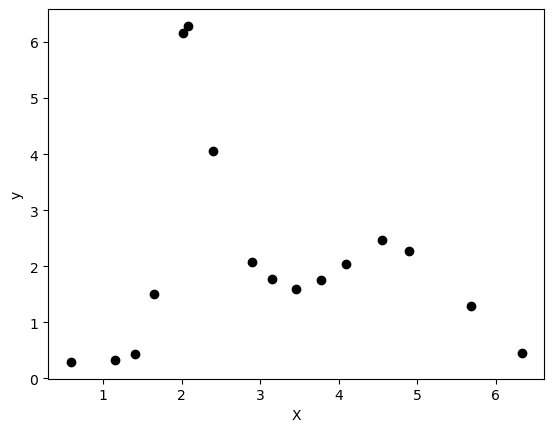

In [2]:
import matplotlib.pyplot as plt

X = np.array(df["log-conc"])[:, None]
y = np.array(df["log-zsv"])[:, None]

plt.plot(X, y, "ko", label="Training Data")
plt.xlabel("X")
plt.ylabel("y")

## Train/Test Split and Scaling (as in Lecture 7)
Scaling is important for kernels (just like activations in NNs). We'll standardize `x` to improve length-scale interpretability and conditioning.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize X (fit on train, apply to both train/test)
x_scaler = StandardScaler()
Xtr_s = x_scaler.fit_transform(Xtr)
Xte_s = x_scaler.transform(Xte)

Xtr_s[:5], ytr[:5]

(array([[ 0.8390746 ],
        [-0.94550529],
        [-0.35595667],
        [ 0.51321199],
        [ 0.04478966]]),
 array([[2.47751168],
        [6.28640285],
        [2.08477417],
        [2.05003538],
        [1.58764785]]))

## Gaussian Process in scikit-learn
We'll start with an RBF kernel. scikit-learn will **optimize hyperparameters** by maximizing the log marginal likelihood.

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.metrics import r2_score

# Kernel: RBF - the "most famous" one
kernel =  RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))

gpr = GaussianProcessRegressor(alpha=0.1,
                               kernel=kernel, 
                               normalize_y=True, 
                               random_state=0, 
                               n_restarts_optimizer=5)
gpr.fit(Xtr_s, ytr)

print("Optimized kernel:", gpr.kernel_)
print("Optimized kernel parameters:", gpr.kernel_.get_params())

Optimized kernel: RBF(length_scale=0.235)
Optimized kernel parameters: {'length_scale': np.float64(0.23497730388535837), 'length_scale_bounds': (0.001, 1000.0)}


In [5]:
gpr.get_params()

{'alpha': 0.1,
 'copy_X_train': True,
 'kernel__length_scale': 1.0,
 'kernel__length_scale_bounds': (0.001, 1000.0),
 'kernel': RBF(length_scale=1),
 'n_restarts_optimizer': 5,
 'n_targets': None,
 'normalize_y': True,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': 0}

### Predictions with uncertainty
We compute predictive mean and standard deviation on a grid for visualization. The **uncertainty region** (mean ± 2 std) illustrates the distribution-over-functions perspective.

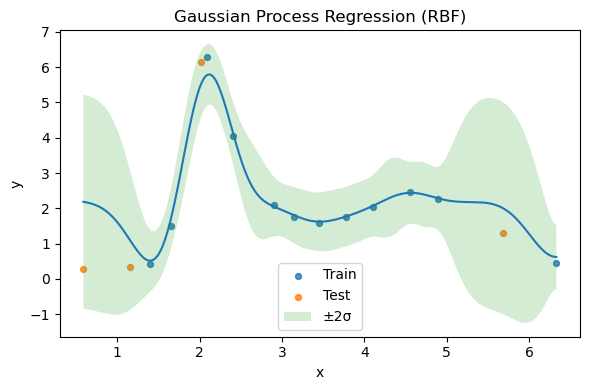

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Create a sorted grid over the range of X for a clean plot
x_min, x_max = X.min(), X.max()
xx = np.linspace(x_min, x_max, 400)[:, None]
xx_s = x_scaler.transform(xx)

y_mean, y_std = gpr.predict(xx_s, return_std=True)

plt.figure(figsize=(6,4))
plt.scatter(Xtr[:,0], ytr, s=18, alpha=0.8, label='Train')
plt.scatter(Xte[:,0], yte, s=18, alpha=0.8, label='Test')
plt.plot(xx[:,0], y_mean)
plt.fill_between(xx[:,0], y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.2, label='±2σ')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Process Regression (RBF)')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Quantitative evaluation
yte_pred, yte_std = gpr.predict(Xte_s, return_std=True)
r2 = r2_score(yte, yte_pred)
print(f"Test R^2: {r2:.3f}")

Test R^2: 0.783


## Design choices : Hyperparameters (again)
As in the NN lecture (layers/neurons/activations), here we choose:
1. **Kernel family** (RBF, Matérn, periodic, sums/products)
2. **Length scale** $\ell$ (controls smoothness / correlation distance)
3. **Signal variance** $\sigma_f^2$ (output scale)
4. **Noise variance** $\sigma_n^2$ (observation noise)
5. **Input scaling** (standardization)

We usually choose these by maximizing the marginal likelihood (as above), cross-validation, or domain-informed priors (physics).

## Variations: Matérn kernel and periodic structure
Try swapping the kernel. Below we demonstrate Matérn($\nu=3/2$); you can also add periodic components if your phenomenon is periodic.

Optimized Matérn kernel: 1.02**2 * Matern(length_scale=0.271, nu=1.5) + WhiteKernel(noise_level=1.1e-08)


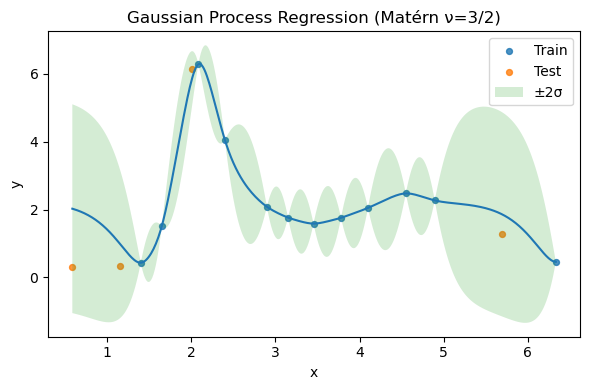

In [8]:
from sklearn.gaussian_process.kernels import Matern

matern_kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=1.5, length_scale_bounds=(1e-3, 1e3)) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-9, 1e1))
gpr_m = GaussianProcessRegressor(kernel=matern_kernel, normalize_y=True, random_state=0, n_restarts_optimizer=5)
gpr_m.fit(Xtr_s, ytr)
print("Optimized Matérn kernel:", gpr_m.kernel_)

y_mean_m, y_std_m = gpr_m.predict(xx_s, return_std=True)

plt.figure(figsize=(6,4))
plt.scatter(Xtr[:,0], ytr, s=18, alpha=0.8, label='Train')
plt.scatter(Xte[:,0], yte, s=18, alpha=0.8, label='Test')
plt.plot(xx[:,0], y_mean_m)
plt.fill_between(xx[:,0], y_mean_m - 2*y_std_m, y_mean_m + 2*y_std_m, alpha=0.2, label='±2σ')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Process Regression (Matérn ν=3/2)')
plt.legend()
plt.tight_layout()
plt.show()

## Strengths and Weaknesses
**Strengths**
- Flexible, probabilistic predictions with calibrated uncertainty.
- Interpretable kernels can be crafted.
- Automatic Occam's razor via marginal likelihood.

**Weaknesses**
- $\mathcal{O}(N^3)$ scaling; expensive for large $N$ (consider sparse/approximate GPs)
- Kernel choice matters (inductive bias)
- Requires careful scaling/normalization and validation

## Summary
- **GP = distribution over functions** (nonparametric regression)
- **Training = hyperparameter optimization** via marginal likelihood
- **Kernels** encode smoothness/structure; length scale $\ell$, signal variance $\sigma_f^2$, noise $\sigma_n^2$
- **scikit-learn** makes GPR straightforward; always mind **scaling**
- Use **uncertainty bands** to communicate confidence in predictions

## References & Further Reading
- scikit-learn: Gaussian Processes — https://scikit-learn.org/stable/modules/gaussian_process.html
- Rasmussen & Williams (2006), *Gaussian Processes for Machine Learning* (MIT Press)
- Hoffman, H.; Rehage, H. (1988) *Rheological properties of viscoelastic surfactant systems*, **J. Phys. Chem.**, 92(16), 4712–4719.
- [Data science and machine learning in engineering and science](https://kitchingroup.cheme.cmu.edu/s24-06642/intro.html)